>>> 1. 读取数据...
>>> 2. 执行数据切分...
训练集: (29894, 165), 测试集: (16670, 165)

>>> [Model 4] 训练 Random Forest...

==================== Random Forest 评估结果 ====================
🔴 Illicit F1-Score: 0.8126
🔴 Recall (抓全率):   0.6888
🔴 Precision (准确率): 0.9907
🔵 ROC-AUC:          0.9260


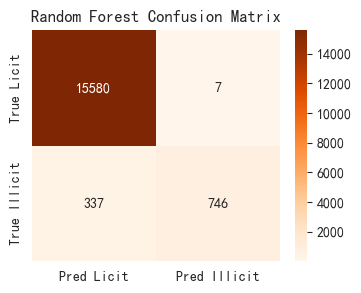


>>> [Model 5] 训练 XGBoost...
XGBoost scale_pos_weight 设置为: 7.63

==================== XGBoost 评估结果 ====================
🔴 Illicit F1-Score: 0.7257
🔴 Recall (抓全率):   0.7415
🔴 Precision (准确率): 0.7106
🔵 ROC-AUC:          0.9295


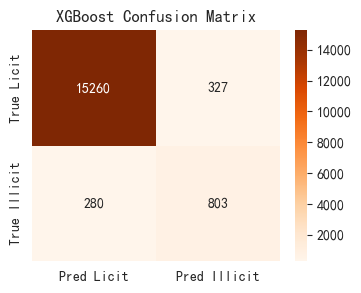

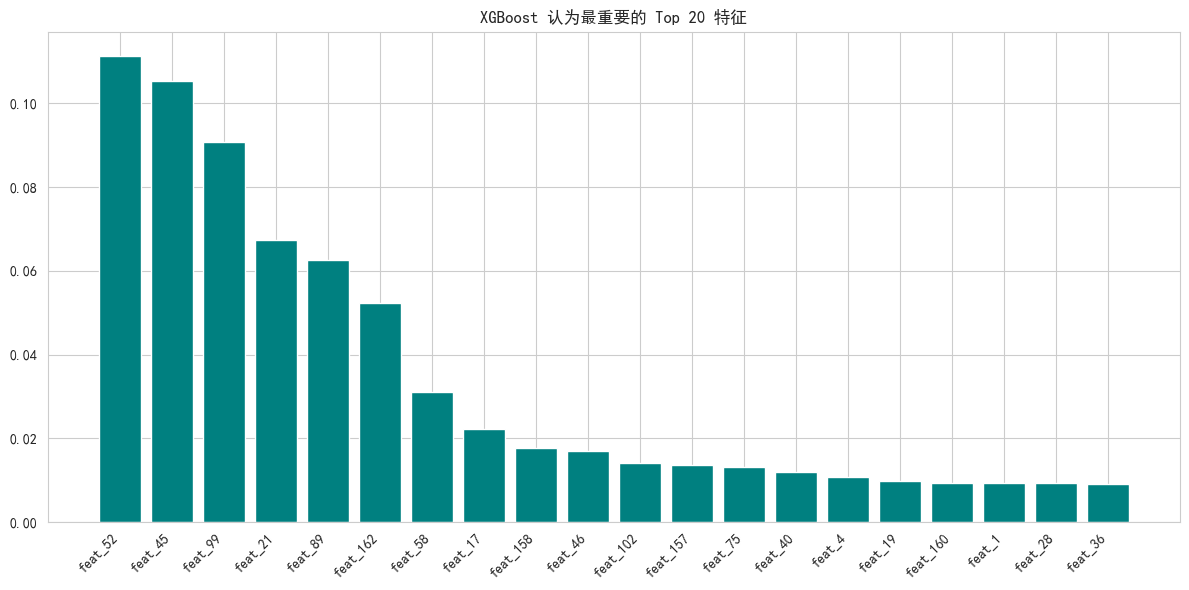


>>> 集成模型 vs 传统模型对比 <<<
                     F1-Score    Recall  Precision   ROC-AUC
Model                                                       
Random Forest        0.812636  0.688827   0.990704  0.925971
XGBoost              0.725712  0.741459   0.710619  0.929467
Decision Tree (Ref)  0.547900  0.744200   0.433600  0.887900


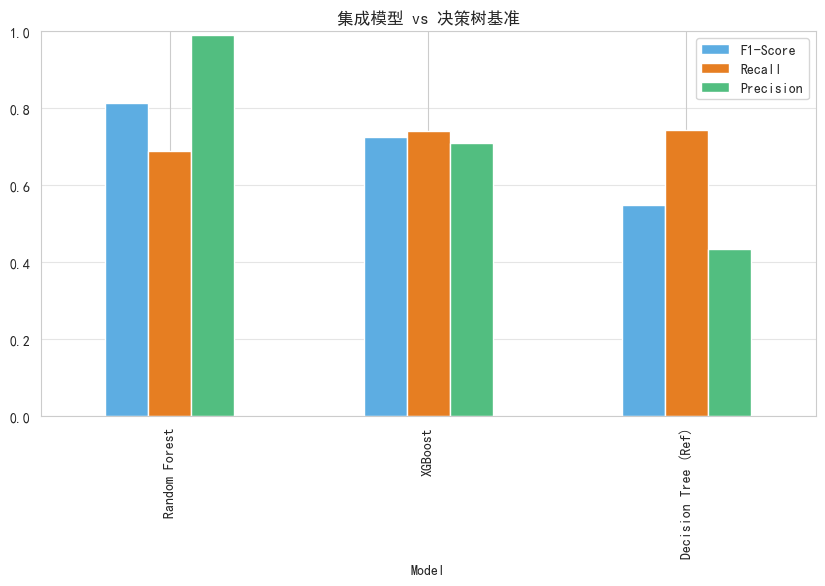

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理 (同上一步)
# ==========================================
print(">>> 1. 读取数据...")
df = pd.read_csv('../data/processed/elliptic_benchmark.csv')

print(">>> 2. 执行数据切分...")
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

# 准备特征
# 同样的剔除逻辑
cols_to_drop = ['txId', 'label', 'split', 'Time step', 'time_step']
existing_drop_cols = [c for c in cols_to_drop if c in df.columns]

X_train = train_df.drop(columns=existing_drop_cols)
y_train = train_df['label']
X_test = test_df.drop(columns=existing_drop_cols)
y_test = test_df['label']

print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")

# 注意：树模型(RF, XGB)不需要特征标准化(StandardScaler)，它们对数值量纲不敏感
# 所以这里直接用原始数据即可

# ==========================================
# 2. 定义评估函数
# ==========================================
results_list = []

def evaluate_model(model, name, X_test, y_test):
    print(f"\n{'='*20} {name} 评估结果 {'='*20}")

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    f1 = f1_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    prec = precision_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0

    print(f"🔴 Illicit F1-Score: {f1:.4f}")
    print(f"🔴 Recall (抓全率):   {rec:.4f}")
    print(f"🔴 Precision (准确率): {prec:.4f}")
    print(f"🔵 ROC-AUC:          {auc:.4f}")

    results_list.append({
        'Model': name,
        'F1-Score': f1, 'Recall': rec, 'Precision': prec, 'ROC-AUC': auc
    })

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Pred Licit', 'Pred Illicit'],
                yticklabels=['True Licit', 'True Illicit'])
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# ==========================================
# 3. 模型 A: Random Forest (随机森林)
# ==========================================
print("\n>>> [Model 4] 训练 Random Forest...")
# n_estimators=100: 100棵树
# class_weight='balanced': 处理不平衡
# n_jobs=-1: 使用所有CPU核加速
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

evaluate_model(rf, "Random Forest", X_test, y_test)

# ==========================================
# 4. 模型 B: XGBoost (极端梯度提升树)
# ==========================================
print("\n>>> [Model 5] 训练 XGBoost...")

# 计算负正样本比例 (用于 scale_pos_weight)
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_weight = neg_count / pos_count
print(f"XGBoost scale_pos_weight 设置为: {scale_weight:.2f}")

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,         # 树深，太深容易过拟合
    learning_rate=0.1,   # 学习率
    scale_pos_weight=scale_weight, # 关键：处理不平衡
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

evaluate_model(xgb, "XGBoost", X_test, y_test)

# ==========================================
# 5. 特征重要性分析 (Feature Importance)
# ==========================================
# 我们看 XGBoost 认为哪些特征最重要
importances = xgb.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1][:20] # 取前20个

plt.figure(figsize=(12, 6))
plt.title("XGBoost 认为最重要的 Top 20 特征")
plt.bar(range(20), importances[indices], align="center", color='teal')
plt.xticks(range(20), feature_names[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ==========================================
# 6. 最终对比 (集成模型 vs 传统最佳)
# ==========================================
# 手动把上一步 Decision Tree 的结果加进来做个对比参照
# (注意：这里的数值 0.5479 是你上一次跑出来的结果，如果变了请修改)
results_list.append({
    'Model': 'Decision Tree (Ref)',
    'F1-Score': 0.5479, 'Recall': 0.7442, 'Precision': 0.4336, 'ROC-AUC': 0.8879
})

summary_df = pd.DataFrame(results_list).set_index('Model')
print("\n>>> 集成模型 vs 传统模型对比 <<<")
print(summary_df)

summary_df[['F1-Score', 'Recall', 'Precision']].plot(kind='bar', figsize=(10, 5), color=['#5DADE2', '#E67E22', '#52BE80'])
plt.title("集成模型 vs 决策树基准")
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.5)
plt.show()